This notebook is part of the `deepcell-tf` documentation: https://deepcell.readthedocs.io/.

# Training a segmentation model

`deepcell-tf` leverages [Jupyter Notebooks](https://jupyter.org) in order to train models. Example notebooks are available for most model architectures in the [notebooks folder](https://github.com/vanvalenlab/deepcell-tf/tree/master/notebooks). Most notebooks are structured similarly to this example and thus this notebook serves as a core reference for the deepcell approach to model training.

In [2]:
import os
import errno
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.segmentation import relabel_sequential
from IPython.display import HTML

import deepcell
from deepcell.utils.plot_utils import get_js_video
from deepcell.utils.utils_3D import get_3D_cell_statistics, load_mousebrain_data#, tile_predict_watershed
from deepcell_toolbox.deep_watershed import deep_watershed_3D
from deepcell_toolbox.utils import tile_image_3D, untile_image_3D

## Load data

In [3]:
filepath = '/images/data/cells/MouseBrain/3D_annotations/attempt2'
set_nums = 4
test_size = 0.2
seed = 7

X_train, X_test, y_train, y_test = load_mousebrain_data(filepath, set_nums, test_size=test_size, seed=seed)
print('X_train.shape: {}\ty_train.shape: {}'.format(X_train.shape, y_train.shape))
print('X_test.shape: {}\ty_test.shape: {}'.format(X_test.shape, y_test.shape))

X_train.shape: (11, 47, 512, 512, 1)	y_train.shape: (11, 47, 512, 512, 1)
X_test.shape: (3, 47, 512, 512, 1)	y_test.shape: (3, 47, 512, 512, 1)


## Analyze cell statistics

In [4]:
from skimage.measure import regionprops
import statistics

def get_3D_cell_statistics_r2(images, precision=2, channel=0):

    if images.ndim != 5:
        raise ValueError('Input images must have ndims = 5 (batch, z, x, y, channels)'
                         'Given input had ndims = {}, with shape '.format(images.ndim, images.shape))

    z_dims = []
    x_dims = []
    y_dims = []
    
    vols = []

    for batch in range(images.shape[0]):
        regions = regionprops(images[batch, ..., channel])

        for region in regions:
            vol = region.area
            vols.append(vol)
            
            bbox = region.bbox
            z_dims.append(bbox[3] - bbox[0])
            x_dims.append(bbox[4] - bbox[1])
            y_dims.append(bbox[5] - bbox[2])

    stats = {}
    stats['z_mean'] = np.round(statistics.mean(z_dims), precision)
    stats['x_mean'] = np.round(statistics.mean(x_dims), precision)
    stats['y_mean'] = np.round(statistics.mean(y_dims), precision)
    stats['z_med'] = np.round(statistics.median(z_dims), precision)
    stats['x_med'] = np.round(statistics.median(x_dims), precision)
    stats['y_med'] = np.round(statistics.median(y_dims), precision)
    stats['vols'] = vols
    return stats

In [5]:
stats = get_3D_cell_statistics_r2(np.concatenate((y_train, y_test), axis=0))

print('Cell dimensions: mean x is {}, mean y is {}, and mean z is {}'.format(
    stats['x_mean'], stats['y_mean'], stats['z_mean']))

Cell dimensions: mean x is 36.07, mean y is 38.4, and mean z is 15.95


In [19]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(hX_train, hy_train), (hX_test, hy_test) = deepcell.datasets.hela_s3.load_data(
    filename, test_size=test_size, seed=seed)

6370107392/6370099814 [==============================] - 144s 0us/step


In [24]:
hstats = get_3D_cell_statistics_r2(np.expand_dims(np.concatenate((hy_train.astype(int), hy_test.astype(int)), axis=0), -1))

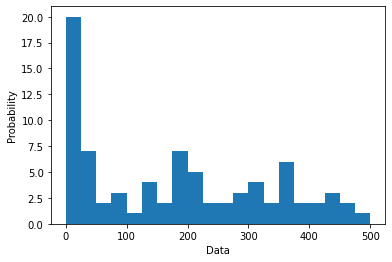

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

vols = stats['vols']


plt.hist(vols, density=False, bins=20, range=(0, 500))  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

## remove less than 450 (radius=6)

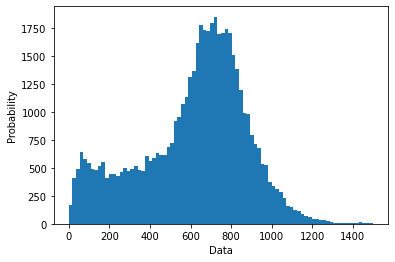

In [30]:
hvols = hstats['vols']


plt.hist(hvols, density=False, bins=84, range=(0, 1500))  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
### below is unneeded for this file

In [4]:
# Set args for image tiling
z_dim = 32
xy_dim = 64
tile_shape = (z_dim+1, xy_dim, xy_dim)
stride_train = 0.35
stride_test = 0.75

# Save an untiled version for metrics analysis
X_test_metrics = np.copy(X_test) 
y_test_metrics = np.copy(y_test)

# Tile images into overlapping tiles
X_train, _ = tile_image_3D(X_train, model_input_shape=tile_shape, stride_ratio=stride_train)
X_test, _ = tile_image_3D(X_test, model_input_shape=tile_shape, stride_ratio=stride_test)

y_train, _ = tile_image_3D(y_train, model_input_shape=tile_shape, stride_ratio=stride_train)
y_test, _ = tile_image_3D(y_test, model_input_shape=tile_shape, stride_ratio=stride_test)

print('X_train.shape: {}\ty_train.shape: {}'.format(X_train.shape, y_train.shape))
print('X_test.shape: {}\ty_test.shape: {}'.format(X_test.shape, y_test.shape))

X_train.shape: (13200, 33, 64, 64, 1)	y_train.shape: (13200, 33, 64, 64, 1)
X_test.shape: (726, 33, 64, 64, 1)	y_test.shape: (726, 33, 64, 64, 1)


## Set up filepath constants


In [5]:
filename = '--.npz'

DATA_DIR = os.path.expanduser(os.path.join(filepath))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/images'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [30]:
temporal_mode = 'lstm'
frames_per_batch = z_dim

In [31]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=frames_per_batch, 
    norm_method='std',
    num_semantic_heads=3,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1, 2], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True)

## Prepare for training

### Set up training parameters

In [32]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

# Change these
model_name = 'mousebrain3D_32x64_TMlstm'
fill_mode = 'nearest'
n_epoch = 1 
batch_size = 3
by_frame_inner = False  # if False, transform inner-distance as 3D, if True transform frame-by-frame
by_frame_outer = True   # if False, transform outer-distance as 3D, if True transform frame-by-frame

# Don't change these
cval = 0
test_size = .20
optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)
min_objects = 1
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

### Create the DataGenerators

The `SemanticDataGenerator` can output any number of transformations for each image. These transformations are passed to `generator.flow()` as a list of transform names.

Here we use `"inner-distance"`, `"outer-distance"` and `"fgbg"` to correspond to the inner distance, outer distance, and foreground background semantic heads, respectively. Keyword arguments may also be passed to each transform as a `dict` of transform names to `kwargs`.

In [34]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0, 'by_frame' : by_frame_outer},
                     'inner-distance': {'by_frame' : by_frame_inner}}

# use augmentation for training but not validation
datagen = image_generators.SemanticMovieGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticMovieGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    frames_per_batch=frames_per_batch,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    frames_per_batch=frames_per_batch,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)


W0719 16:48:09.010190 140439444326208 semantic.py:512] Removing 1618 of 13200 images with fewer than 1 objects.
W0719 16:49:28.173621 140439444326208 semantic.py:512] Removing 98 of 726 images with fewer than 1 objects.


Visualize the data generator output.

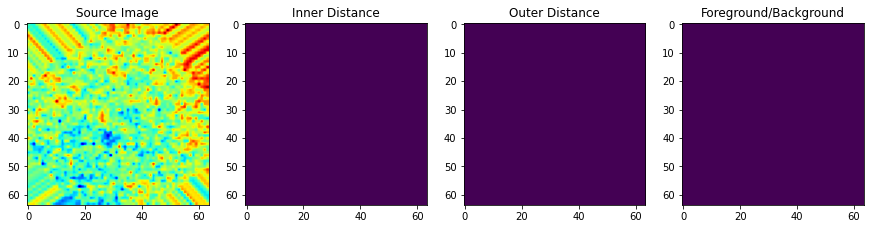

In [35]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

slice=12

axes[0].imshow(img[slice, ..., 0], cmap='jet')
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, slice, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, slice, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, slice, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

In [36]:
# Uncomment to see videos of data_generator output

# Inner_distance
# HTML(get_js_video(outputs[0], batch=0, channel=0, interval=500, vmin=0, vmax=outputs[1].max()))

# Outer_distance
# HTML(get_js_video(outputs[1], batch=0, channel=0, interval=500, vmin=0, vmax=outputs[1].max()))

# Raw
# HTML(get_js_video(inputs, batch=0, channel=0, interval=500, vmin=0, vmax=inputs.max()))

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [37]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [38]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

Call `fit_generator` on the compiled model, along with a default set of callbacks.

In [39]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
3859/3860 [============================>.] - ETA: 0s - loss: 0.1040 - semantic_0_loss: 0.0362 - semantic_1_loss: 0.0610 - semantic_2_loss: 0.0068
Epoch 00001: val_loss improved from inf to 0.04704, saving model to /images/models/mousebrain3D_32x64_TMlstm.h5
3860/3860 [==============================] - 2440s 632ms/step - loss: 0.1040 - semantic_0_loss: 0.0362 - semantic_1_loss: 0.0610 - semantic_2_loss: 0.0068 - val_loss: 0.0470 - val_semantic_0_loss: 0.0235 - val_semantic_1_loss: 0.0167 - val_semantic_2_loss: 0.0069


## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [23]:
# Instantiate prediction model
from deepcell.model_zoo.panopticnet import PanopticNet       
#pred_model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=frames_per_batch,
    norm_method='std',
    num_semantic_heads=2,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True)

# Load weights
#model.load_weights(model_path, by_name=True)

In [24]:
print(model.summary())

Model: "panopticnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 32, 64, 64,  0                                            
__________________________________________________________________________________________________
td_norm (TimeDistributed)       (None, 32, 64, 64, 1 0           input_0[0][0]                    
__________________________________________________________________________________________________
td_location (TimeDistributed)   (None, 32, 64, 64, 2 0           td_norm[0][0]                    
__________________________________________________________________________________________________
concatenate_location (Concatena (None, 32, 64, 64, 3 0           td_norm[0][0]                    
                                                                 td_location[0][0]      

In [16]:
def tile_predict_watershed(model,
                           X_test,
                           y_true,
                           input_shape,
                           stride_ratio=0.5,
                           min_distance=10,
                           detection_threshold=0.1,
                           distance_threshold=0.1,
                           small_objects_threshold=0):

    # Tile X_test into overlapping tiles
    X_tiles, tiles_info_X = tile_image_3D(X_test, model_input_shape=input_shape, stride_ratio=stride_ratio)
    
    # Predict on tiles 
    y_pred = model.predict(X_tiles, batch_size=batch_size)

    # Untile predictions
    y_pred = [untile_image_3D(o, tiles_info_X, model_input_shape=input_shape) for o in y_pred]
    
    # Run deep_watershed_3D on untiled predictions
    y_pred = deep_watershed_3D(
        y_pred,
        min_distance=min_distance,
        detection_threshold=detection_threshold,
        distance_threshold=distance_threshold,
        exclude_border=False,
        small_objects_threshold=small_objects_threshold)
        
    # Squeeze out channel dimension from y_true
    y_true = np.squeeze(y_true)
    
    # If batch dimension was squeezed out, add it back in
    if y_true.ndim < 4:
        y_true = np.expand_dims(y_true, 0)

    return y_true, y_pred

In [17]:
# Predict on tiles and composite for metrics analysis
input_shape = (frames_per_batch, X_train.shape[2], X_train.shape[3])
stride_ratio = 0.5  
min_distance = 14             # minimum allowable distance between two centroid coords
detection_threshold = 0.05    # absolute threshold for minimum peak intensity
distance_threshold = 0.1      # outer_distance threshold for cell border
batch_size = 1

y_true, y_pred = tile_predict_watershed(model=model,
                                        X_test=X_test_metrics,
                                        y_true=y_test_metrics,
                                        input_shape=input_shape,
                                        stride_ratio=stride_ratio,
                                        min_distance=min_distance,
                                        detection_threshold=detection_threshold,
                                        distance_threshold=distance_threshold,
                                        small_objects_threshold=0)


print('Shape of y_pred is {} and shape of y_true is {}'.format(y_pred.shape, y_true.shape))

Shape of y_pred is (3, 47, 512, 512) and shape of y_true is (3, 47, 512, 512)


## Run Metrics

In [18]:
from deepcell_toolbox.metrics import Metrics

m = Metrics('DeepWatershed - Remove no pixels', seg=False, ndigits=3, cutoff1=0.6, cutoff2=0.1, is_3d=True)
m.calc_object_stats(y_true, y_pred)

/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:115: RuntimeWarning: invalid value encountered in long_scalars
  precision = intersection.sum() / pred.sum()



____________Object-based statistics____________

Number of true cells:		 260
Number of predicted cells:	 0

Correct detections:  0	Recall: 0.0%
Incorrect detections: 0	Precision: nan%

Gained detections: 0	Perc Error: 0.0%
Missed detections: 260	Perc Error: 100.0%
Merges: 0		Perc Error: 0.0%
Splits: 0		Perc Error: 0.0%
Catastrophes: 0		Perc Error: 0.0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.0 



/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:926: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['correct_detections'].sum() / self.stats['n_pred'].sum(),


In [19]:
from skimage.morphology import remove_small_objects

small_objects_threshold = 327 # 4/3pi r^3 / z_scale, with radius = 5.6 (circle with area 100) and z_scale = 2.3

# remove small objects - there are some incorrect annotations of very small cells. Should consider removing before training.
for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=small_objects_threshold)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=small_objects_threshold)

    y_pred[i], _, _ = relabel_sequential(y_pred[i])

In [20]:
from deepcell_toolbox.metrics import Metrics

m = Metrics('DeepWatershed - Remove no pixels', seg=False, ndigits=3, cutoff1=0.6, cutoff2=0.1, is_3d=True)
m.calc_object_stats(y_true, y_pred)


____________Object-based statistics____________

Number of true cells:		 241
Number of predicted cells:	 0

Correct detections:  0	Recall: 0.0%
Incorrect detections: 0	Precision: nan%

Gained detections: 0	Perc Error: 0.0%
Missed detections: 241	Perc Error: 100.0%
Merges: 0		Perc Error: 0.0%
Splits: 0		Perc Error: 0.0%
Catastrophes: 0		Perc Error: 0.0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.0 



Watershed segmentation of shape (1, 32, 64, 64, 1) in 8.14907929697074 seconds.


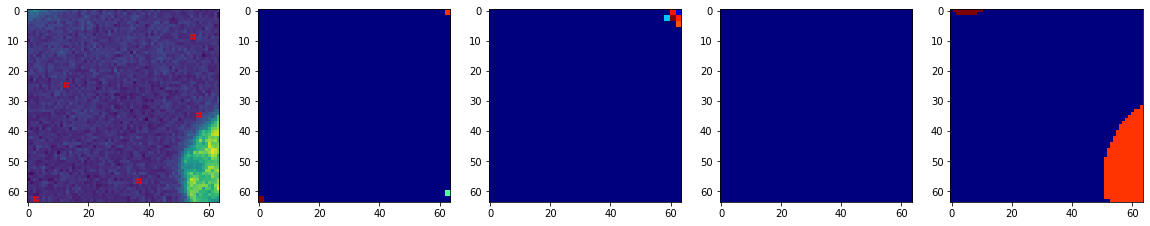

In [40]:
# make predictions on testing data
from timeit import default_timer

f_mov = 24
l_mov = f_mov+1
batch_size = 1

start = default_timer()
test_images = model.predict(X_test[f_mov:l_mov, 0:frames_per_batch, ...], batch_size=batch_size)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')


import time

from matplotlib import pyplot as plt
import numpy as np

from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects


min_distance = 15          # minimum allowable distance between two centroid coords
detection_threshold = 0.01  # absolute threshold for minimum peak intensity (TODO - relative threshold)
distance_threshold = 0.1  # outer_distance threshold for cell border
small_objects_threshold = 0

masks = deep_watershed_3D(
    test_images,
    min_distance=min_distance,
    detection_threshold=detection_threshold,
    distance_threshold=distance_threshold,
    exclude_border=False,
    small_objects_threshold=small_objects_threshold)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

fig, axes = plt.subplots(1, 5, figsize=(20, 20))

index = 0
slice = 28
coords = peak_local_max(
    np.squeeze(inner_distance[index]),
    min_distance=min_distance,
    threshold_abs=detection_threshold,
    exclude_border=False)

# raw image with centroid
axes[0].imshow(X_test[index+f_mov, slice, ..., 0])
axes[0].scatter(coords[..., 2], coords[..., 1],
                color='r', marker='.', s=10)

# raw image xz plane
#axes[0].imshow(X_test[index+f_mov, :, 150, :, 0])
#axes[0].scatter(coords[..., 2], coords[..., 0], color='r', marker='.', s=10)
    
    
axes[1].imshow(inner_distance[index, slice, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, slice, ..., 0], cmap='jet')
axes[3].imshow(masks[index, slice, ...], cmap='jet')
axes[4].imshow(np.squeeze(y_test[index+f_mov, slice, ...]), cmap='jet')

plt.show()


# Play movie of the predicted masks
vid_msk = np.expand_dims(masks, axis=1)
vid_msk = np.expand_dims(vid_msk, axis=-1)
#HTML(get_js_video(vid_msk[index], batch=0, channel=0, interval=500))